In the following, all the code blocks directly related to `pastax` are opened by default,
while the closed ones are not required to learn about the library.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax


jax.config.update("jax_enable_x64", True)

## Defining a velocity field

In the following, we will use an idealized configuration (inspired by [this one](https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html#Running-particles-in-an-idealised-field) from Parcels documentation) where the velocity field $\mathbf{u}$ presents two eddies displaced over time.

We consider a spatial domain spanning from 29° to 31° latitude and -1° to 1° longitude, and a time period of two days.

In [4]:
import jax.numpy as jnp


ny = nx = 101
nt = 49

lat = jnp.linspace(29, 31, ny)
lon = jnp.linspace(-1, 1, nx)

dt = jnp.asarray(1 * 60 * 60)  # 1 hour in seconds
ts = jnp.linspace(0, dt * (nt - 1), nt)  # discretize interval of 2 days in seconds

Below we defined the $\mathbf{u}_u$ and $\mathbf{u}_v$ fields, considering circular and geostrophic eddies.

In [5]:
from pastax.utils import degrees_to_meters


dy, dx = degrees_to_meters(jnp.asarray([lat[1] - lat[0], lon[1] - lon[0]]), lat.mean())

# SSH field parameters
eta0 = 0.4
sig = 0.1
eta_fn = lambda _dx, _dy: eta0 * jnp.exp(-((_dx / (sig * nx)) ** 2) - (_dy / (sig * ny)) ** 2)
xi, yi = jnp.meshgrid(jnp.arange(lon.size), jnp.arange(lat.size), indexing="ij")

# eddies displacement parameters
eddy_speed = 0.05
dxi = eddy_speed * dt / dx
dyi = eddy_speed * dt / dy

# SSH field
eta = jnp.zeros((nt, ny, nx))
for t in range(nt):
    # eddy 1
    x1 = 0.5 * lon.size - (8 + dxi * t)
    y1 = 0.5 * lat.size - (8 + dyi * t)
    eta = eta.at[t, :, :].add(eta_fn((x1 - xi), (y1 - yi)))

    # eddy 2
    x2 = 0.5 * lon.size + (8 + dxi * t)
    y2 = 0.5 * lat.size + (8 + dyi * t)
    eta = eta.at[t, :, :].add(-eta_fn((x2 - xi), (y2 - yi)))

# geostrophic velocities
coriolis_factor = 2 * 7.292115e-5 * jnp.sin(jnp.radians(lat.mean()))
g = 9.81

u = jnp.zeros_like(eta)
u = u.at[:, :-1, :].set(jnp.diff(eta[:, :, :], axis=1) / dy / coriolis_factor * g)
u = u.at[:, -1, :].set(u[:, -2, :])

v = jnp.zeros_like(eta)
v = v.at[:, :, :-1].set(-jnp.diff(eta[:, :, :], axis=-1) / dx / coriolis_factor * g)
v = v.at[:, :, -1].set(v[:, :, -2])

Looking at $\| \mathbf{u} \|$ over time we can see how the eddies separate.

In [ ]:
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation


plt.ioff()


fig, ax = plt.subplots()

im = ax.pcolormesh(lon, lat, jnp.sqrt(u[0] ** 2 + v[0] ** 2), vmax=2.75, vmin=0, cmap=cmo.speed)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
_ = clb.ax.set_title("$m/s$")

quiver = ax.quiver(lon[::5], lat[::5], u[0][::5, ::5], v[0][::5, ::5], scale=50)

ax.set_aspect("equal")
title = ax.set_title(f"$t$ = {ts[0] / 60 / 60:.0f}h")


def draw_frame(i):
    im.set_array(jnp.sqrt(u[i] ** 2 + v[i] ** 2).ravel())
    quiver.set_UVC(u[i][::5, ::5], v[i][::5, ::5])
    title.set_text(f"$t$ = {ts[i] / 60 / 60:.0f}h")

    return im, quiver, title


def init_func():
    return draw_frame(0)


anim = animation.FuncAnimation(fig, draw_frame, init_func=init_func, frames=nt, interval=100, blit=True)
HTML(anim.to_html5_video())

In order to interpolate this velocity field during simulations of trajectories, we define a [`pastax.gridded.Gridded`][] (a `xarray.Dataset`-likish object compatible with JAX just-in-time compilation mechanism).

In [7]:
from pastax.gridded import Gridded


two_eddies_grid = Gridded.from_array(
    fields={"u": u, "v": v},  # the fields
    time=ts,
    latitude=lat,
    longitude=lon,  # the coordinates
)

## Simulating trajectories

The initial position of the simulated trajectories is chosen to be right in between the two eddies: 30° latitude and 0° longitude.
We use a [`pastax.trajectory.Location`][] to represent this location.

In [8]:
from pastax.trajectory import Location


x0 = Location([30, 0])

We also define the time range of the simulated trajectory, and the initial integration timestep.

In [9]:
ts_sim = ts[1:-1]
dt0 = jnp.asarray(15 * 60)  # integration timestep: 15 minutes in seconds

### Generating a single trajectory

Let's start with the simplest use-case: advecting a single particle inside a given velocity field $\mathbf{u}$.

For this, we use a [`pastax.simulator.DeterministicSimulator`][] simulator, and a [`pastax.dynamics.linear_uv`][] dynamics.

??? example "Formulation"

    This combination of simulator and dynamics formulates the displacement at time $t$ from the position $\mathbf{X}(t)$ as:

    $$
    d\mathbf{X}(t) = \mathbf{u}(t, \mathbf{X}(t)) dt
    $$

    by interpolating the velocity field $\mathbf{u}$ in space and time.

In [10]:
from pastax.dynamics import linear_uv
from pastax.simulator import DeterministicSimulator


traj_sim = DeterministicSimulator()
uv_dynamics = linear_uv

[`pastax.simulator.BaseSimulator`][] simulators are *callables* returning a simulated [`pastax.trajectory.Trajectory`][] (or a [`pastax.trajectory.TrajectoryEnsemble`][] as we will see later).

In [11]:
traj = traj_sim(dynamics=uv_dynamics, args=two_eddies_grid, x0=x0, ts=ts_sim, dt0=dt0)

We can plot trajectories using their [`pastax.trajectory.Trajectory.plot`][] method.

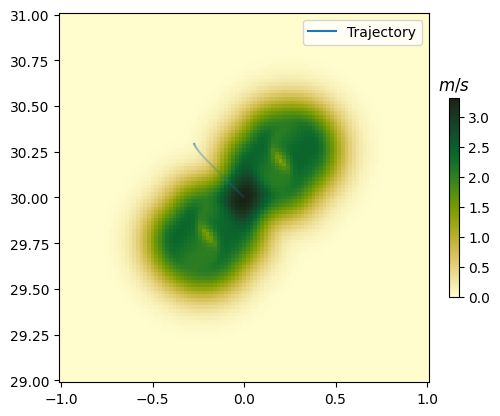

In [ ]:
plt.close()

fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(lon, lat, jnp.sqrt((u**2 + v**2)).max(axis=0), cmap=cmo.speed, vmin=0)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
_ = clb.ax.set_title("$m/s$")

# add the trajectory
ax = traj.plot(ax, label="Trajectory", color="tab:blue")

ax.set_aspect("equal")
ax.legend()

plt.show()

Since the particle is released right between the eddies, its trajectory is perpendicular (up to numerical approximations) to the direction of the eddies.
Because of smaller scales processes (not represented by our geostrophic velocity fields) this very unlikely to happen in practice, even if two eddies were to separate in exactly opposite ways (which is also very unlikely of course).

To get an idea of the different possible "realistic" trajectories we will next generate a stochastic ensemble.

### Sampling an ensemble of trajectories

Instead of a single trajectory, we will now simulate an ensemble of 100 trajectories by sampling solutions from a Stochastic Differential Equation with Smagorinsky diffusion using the [`pastax.simulator.StochasticSimulator`][] simulator and a [`pastax.dynamics.StochasticSmagorinskyDiffusion`][].

??? example "Formulation"

    This combination of simulator and dynamics formulates a displacement at time $t$ from the position $\mathbf{X}(t)$ as:

    $$
    d\mathbf{X}(t) = (\mathbf{u} + \nabla K)(t, \mathbf{X}(t)) dt + V(t, \mathbf{X}(t)) d\mathbf{W}(t)
    $$

    where $V = \sqrt{2 K}$ and $K$ is the Smagorinsky diffusion:
    
    $$
    K = C_s \Delta x \Delta y \sqrt{\left(\frac{\partial u}{\partial x} \right)^2 + \left(\frac{\partial v}{\partial y} \right)^2 + \frac{1}{2} \left(\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \right)^2}
    $$

    where $C_s$ is the ***tunable*** Smagorinsky constant, $\Delta x \Delta y$ a spatial scaling factor, and the rest of the expression represents the horizontal diffusion.

In [ ]:
from pastax.dynamics import StochasticSmagorinskyDiffusion
from pastax.simulator import StochasticSimulator


n_samples = jnp.asarray(100)

ens_sim = StochasticSimulator()
smag_dynamics = StochasticSmagorinskyDiffusion.from_cs(cs=1e-1)

traj_ens = ens_sim(
    dynamics=smag_dynamics,
    args=two_eddies_grid,
    x0=x0,
    ts=ts_sim,
    dt0=dt0,
    n_samples=n_samples,
)

This time, the simulator returns a [`pastax.trajectory.TrajectoryEnsemble`][].
Again, we can plot it using the [`pastax.trajectory.TrajectoryEnsemble.plot`][] method.

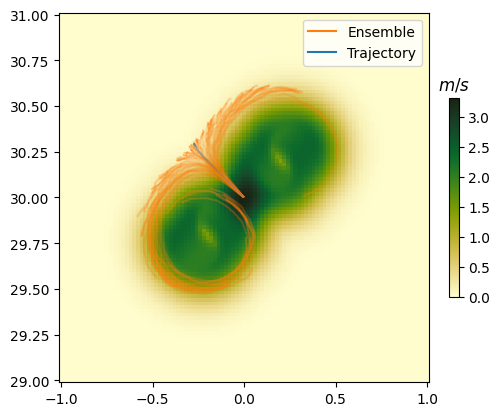

In [ ]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(lon, lat, jnp.sqrt((u**2 + v**2)).max(axis=0), cmap=cmo.speed, vmin=0)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
_ = clb.ax.set_title("$m/s$")

# add the ensemble
ax = traj_ens.plot(ax, label="Ensemble", color="tab:orange")

# add the trajectory on top
ax = traj.plot(ax, label="Trajectory", color="tab:blue")

ax.set_aspect("equal")
ax.legend()

plt.show()

We see that the ensemble much better represent the presence of the two eddies.

## Learning simulators parametrization

Using [`JAX`](https://jax.readthedocs.io/) we have the ability to write fully differentiable simulators and learn their parametrization (even for a large number of parameters, such as a neural network).

### In a controlled deterministic case

We stick to our idealized velocity field $\mathbf{u}$ and consider a ***reference*** (pair of simulator and) dynamics ($\mathcal{S}_\text{ref}$) whose output will be considered as the truth and a ***tunable*** (pair of simulator and) dynamics ($\mathcal{S}_\text{tun}$) that we will want to calibrate according to the truth.

Here, the ***reference*** dynamics knows and uses $\mathbf{u}$ to simulate the ***true*** trajectory.
The ***tunable*** dynamics uses as input a modified version of the velocity field: $\widehat{\mathbf{u}} = (\mathbf{u} - b) / a$, and apply the linear transformation $x \mapsto \beta_0 + x \beta_1$ to $\widehat{\mathbf{u}}$ to simulate an ***estimated*** trajectory.

Starting from randomly sampled $\beta_0$ and $\beta_1$, we will (hopefully) learn their expected values $b$ and $a$ by minimizing (using a gradient-based optimizer) a metric $\mathcal{L}$ quantifying the distance between the ***true*** and ***estimated*** trajectories:

$$
(\beta_0^*, \beta_1^*) = \underset{\beta_0, \beta_1}{\operatorname{argmin}} \mathcal{L}(\mathcal{S}_\text{ref}(t_0, \mathbf{X}_0), \mathcal{S}_\text{tun}(t_0, \mathbf{X}_0))
$$

In [15]:
true_grid = two_eddies_grid  # same as before

# velocity field transofrmation parameters
a = 2
b = 0.1

# transformed velocity field
trans_u = (u - b) / a
trans_v = (v - b) / a
trans_grid = Gridded.from_array(
    fields={"u": trans_u, "v": trans_v},  # the fields
    time=ts,
    latitude=lat,
    longitude=lon,  # the coordinates
)

As before, we use a [`pastax.dynamics.linear_uv`][] dynamics for the ***reference*** $\mathcal{S}_\text{ref}$.
For the ***tunable*** one $\mathcal{S}_\text{tun}$, we use a [`pastax.dynamics.LinearUV`][], whose `intercept` and `slope` attributes can be optimized.

In [16]:
import jax.random as jrd

from pastax.dynamics import LinearUV


ref_dynamics = linear_uv

keys = jrd.split(jrd.key(0), 2)
intercept = jrd.uniform(keys[0], 1, dtype=float, minval=-1, maxval=1)
slope = jrd.uniform(keys[1], 1, dtype=float, minval=-1, maxval=1)
tun_dynamics = LinearUV(intercept=intercept, slope=slope)

print(f"Initial parameters: (intercept={intercept.item()}, slope={slope.item()})")

Initial parameters: (intercept=-0.03947928024531988, slope=0.15310165206863147)


To make the example more interesting, we are going to use a different initial position and start inside the leftward eddy.

In [17]:
x0 = Location([29.95, -0.05])

Let's see how the true and estimated trajectories compare:

In [18]:
true_traj = traj_sim(dynamics=ref_dynamics, args=true_grid, x0=x0, ts=ts_sim, dt0=dt0)
est_traj_init = traj_sim(dynamics=tun_dynamics, args=trans_grid, x0=x0, ts=ts_sim, dt0=dt0)

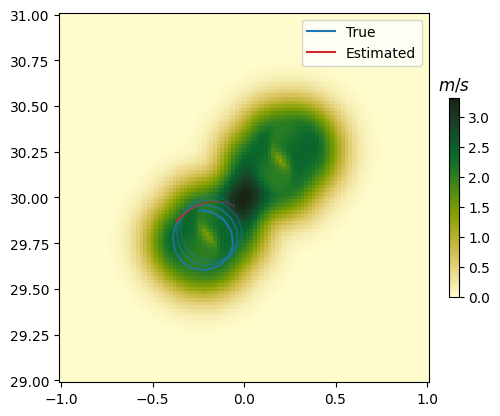

In [ ]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(lon, lat, jnp.sqrt((u**2 + v**2)).max(axis=0), cmap=cmo.speed, vmin=0)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
_ = clb.ax.set_title("$m/s$")

# add the reference
ax = true_traj.plot(ax, label="True", color="tab:blue")

# add the estimation
ax = est_traj_init.plot(ax, label="Estimated", color="tab:red")

ax.set_aspect("equal")
ax.legend()

plt.show()

As expected given the sampled values of $\beta_0$ and $\beta_1$, the estimated trajectory is quite far from the true one.

To improve this estimation by adjusting the parameters $\beta_0$ and $\beta_1$ automatic differentiation and using gradient descent, we essentially need to define our objective function (or loss) $\mathcal{L}$ to minimize, and a minimizer.

There is plenty of options for the choice objective function, including:

- the Liu Index,
- the Separation distance (distance on Earth in meters),
- the Euclidean distance (distance in degrees),
- ...

that we can evaluate either at the final position of the particle or along its full trajectory.

In this case, we will use the sum of the Liu Index calculated every hour between the true and the estimated trajectories, that we square to ease minimization.

In [20]:
import equinox as eqx


def sim_fn(dynamics):
    return traj_sim(dynamics, args=trans_grid, x0=x0, ts=ts_sim, dt0=dt0)


def loss_fn(traj):
    return (true_traj.liu_index(traj).sum() ** 2).value


def sim_and_eval(dynamics):
    traj = sim_fn(dynamics)
    return loss_fn(traj), traj


val_grad_fn = eqx.filter_value_and_grad(sim_and_eval, has_aux=True)

!!! note
    [`pastax.trajectory.Trajectory`][] objects define several methods to compute metrics or distances between trajectories, such as `liu_index` here.

!!! note
    We use [`Equinox`](https://docs.kidger.site/equinox/) to represent and manipulate (e.g. `vmap`, `grad`, `jit`...) Python structures as PyTrees.

We can verify it is possible to evaluate the initial loss and its gradient.

In [21]:
(loss, _), grads = val_grad_fn(tun_dynamics)

print(f"Initial loss: {loss} and " f"gradients: (intercept={grads.intercept.item()}, slope={grads.slope.item()})")

Initial loss: 269.0459116176965 and gradients: (intercept=594.0834905447703, slope=-120.4831649806624)


Thanks to [`Optax`](https://optax.readthedocs.io/), we have access to a large variety of optimizers.
In this example we will use the classical Adam, but many more are available.

In [22]:
import optax


n_steps = 100
learning_rate = 1e-1

optim = optax.adam(learning_rate, b1=0.5)
optim = optax.apply_if_finite(optim, max_consecutive_errors=n_steps)
opt_state = optim.init(tun_dynamics)

Because we rely on [`Equinox`](https://docs.kidger.site/equinox/), it is also straightforward to apply gradient-based updates to the dynamics attributes (as it is a PyTree).

In [23]:
@eqx.filter_jit
def make_step(dynamics, opt_state):
    (loss, traj), grads = val_grad_fn(dynamics)
    updates, opt_state = optim.update(grads, opt_state)
    dynamics = eqx.apply_updates(dynamics, updates)
    return loss, traj, dynamics, opt_state

!!! note
    This function should be jitted.

Finally, we perform the optimization over 100 steps:

In [24]:
trajs = []
losses = []
dyns = [
    tun_dynamics,
]

for step in range(n_steps):
    loss, traj, tun_dynamics, opt_state = make_step(tun_dynamics, opt_state)
    trajs.append(traj)
    losses.append(loss)
    dyns.append(tun_dynamics)

tun_dynamics_final = dyns[-1]
loss_final, est_traj_final = sim_and_eval(tun_dynamics_final)
trajs.append(est_traj_final)
losses.append(loss_final)

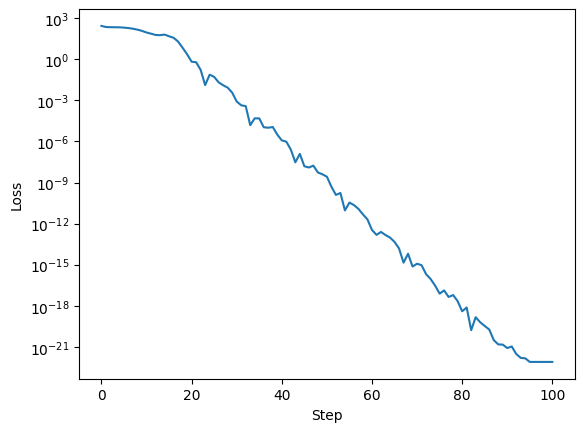

In [25]:
fig, ax = plt.subplots()

ax.plot(jnp.asarray(losses).ravel())

ax.set_yscale("log")
ax.set_xlabel("Step")
ax.set_ylabel("Loss")

plt.show()

After optimization, the fitted parameters of the calibrated simulator correspond to their expected values:

In [26]:
print(f"Final parameters: (intercept={tun_dynamics_final.intercept.item()}, slope={tun_dynamics_final.slope.item()})")

Final parameters: (intercept=0.09999999999989573, slope=2.000000000000269)


Therefore, we should now find a very good agreement between the two trajectories.

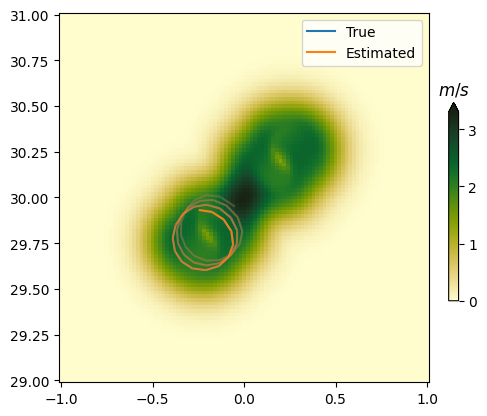

In [ ]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(
    lon,
    lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0),
    cmap=cmo.speed,
    vmin=0,
    vmax=jnp.sqrt((u**2 + v**2)).max(),
)
clb = fig.colorbar(im, ax=ax, extend="max", orientation="vertical", fraction=0.02, pad=0.04)
_ = clb.ax.set_title("$m/s$")

# add the reference
ax = true_traj.plot(ax, label="True", color="tab:blue")

# add the estimation
ax = est_traj_final.plot(ax, label="Estimated", color="tab:orange")

ax.set_aspect("equal")
ax.legend()

plt.show()

And indeed, in this toy use-case, we were able to perfectly simulate the reference trajectory.

!!! tip "Bonus 1"

    We can take a look at what happened during the optimization process.

    In particular, how the "corrected" transformed velocity field evolved, and how it affected the ***estimated*** trajectory.
    We can also track the evaluation of the objective function and the value of the estimated parameters along the optimization.

In [28]:
def format_out_float(x):
    if x < 1e-3:
        return f"{x:.3e}"
    else:
        return f"{x:.5f}"


def corrected_vel_norm(dynamics):
    return jnp.sqrt(
        (trans_u * dynamics.slope + dynamics.intercept) ** 2 + (trans_v * dynamics.slope + dynamics.intercept) ** 2
    ).max(axis=0)


def info_text(dynamics, loss):
    loss_text = f"Loss: {format_out_float(loss)}"
    intercept_text = f"Intercept: {format_out_float(dynamics.intercept.item())}"
    slope_text = f"Slope: {format_out_float(dynamics.slope.item())}"
    return f"{loss_text}\n{intercept_text}\n{slope_text}"


est_lines = ax.collections[-1]
text = ax.text(
    0.03,
    0.965,
    "",
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.75},
)
title = ax.set_title("")


def draw_step(i):
    dynamics = dyns[i]
    traj = trajs[i]
    loss = losses[i]

    im.set_array(corrected_vel_norm(dynamics).ravel())

    locations = traj.locations.value[:, None, ::-1]
    segments = jnp.concat((locations[:-1], locations[1:]), axis=1)
    est_lines.set_segments(segments)

    text.set_text(info_text(dynamics, loss))

    title.set_text(f"step: {i}")

    return im, est_lines, text, title


def init_func():
    return draw_step(0)


anim = animation.FuncAnimation(fig, draw_step, init_func=init_func, frames=n_steps, interval=100, blit=True)
HTML(anim.to_html5_video())

!!! tip "Bonus 2"

    As we are optimizing only 2 parameters, we can easily inspect the "landscape" of the loss function and its gradient.

In [29]:
# parameters domain
betas0 = jnp.arange(-0.5, 0.5, 0.01)
betas1 = jnp.arange(-1, 3, 0.05)
betas0, betas1 = jnp.meshgrid(betas0, betas1, indexing="ij")

# evaluate the loss and gradient landscapes
(loss_landscape, _), grad_landscape = jax.vmap(
    lambda intercept, slope: val_grad_fn(LinearUV(intercept=intercept, slope=slope)),
    in_axes=(0, 0),
)(betas0.ravel(), betas1.ravel())

loss_landscape = loss_landscape.reshape(betas0.shape)
grad_intercept_landscape = grad_landscape.intercept.reshape(betas0.shape)
grad_slope_landscape = grad_landscape.slope.reshape(betas0.shape)

!!! note

    See how using `jax.map` makes it easy (and fast) to simulate a trajectory and evaluate the loss and its gradient for every parameters pair of our domain.

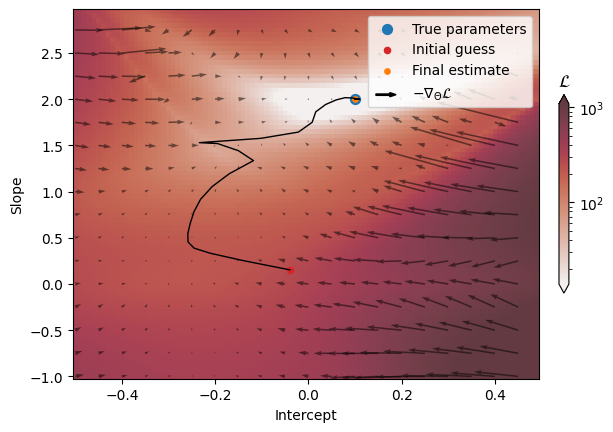

In [30]:
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase


class ArrowHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        arrow = mpatches.FancyArrow(2, 2, 10, 0, color=orig_handle.get_edgecolor(), width=1)
        return [arrow]


intercepts = jnp.asarray([dyns[i].intercept for i in range(n_steps + 1)]).ravel()
slopes = jnp.asarray([dyns[i].slope for i in range(n_steps + 1)]).ravel()

fig, ax = plt.subplots()

ax.set_xlabel("Intercept")
ax.set_ylabel("Slope")

vmax = jnp.quantile(loss_landscape.ravel(), 0.975)
vmin = jnp.quantile(loss_landscape.ravel(), 0.025)

im = ax.pcolormesh(
    betas0,
    betas1,
    loss_landscape,
    cmap=cmo.amp,
    norm="log",
    vmin=vmin,
    vmax=vmax,
    alpha=0.8,
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04, extend="both")
_ = clb.ax.set_title("$\\mathcal{L}$")

ax.quiver(
    betas0[::5, ::5],
    betas1[::5, ::5],
    -grad_intercept_landscape[::5, ::5],
    -grad_slope_landscape[::5, ::5],
    color="black",
    alpha=0.5,
)

ax.scatter(b, a, color="tab:blue", label="True parameters", s=50)
ax.scatter(intercept, slope, color="tab:red", label="Initial guess", s=20)
ax.scatter(intercepts[-1], slopes[-1], color="tab:orange", label="Final estimate", s=15)
ax.plot(intercepts, slopes, color="black", linewidth=1)

handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=handles + [mpatches.FancyArrow(0, 0, 0, 0, color="black", label="$-\\nabla_\Theta \\mathcal{L}$")],
    handler_map={mpatches.FancyArrow: ArrowHandler()},
)

plt.show()

!!! question "Experiment for the reader"

    This idealize scenario is actually quite interesting to adress some questions related to the choice of the objective function:

    - which metric or distance should I use?
    - should I consider the error along the whole trajectory or only at the final position?
  
    Reproducing this section by playing with the objective function will show that the choice of using the squared sum of the Liu Index evaluated every hour is an important one.

### In a real-world stochastic context

!!! tip "For this example we will finally use real data!"

As illustrated by the `pastax` [logo](https://raw.githubusercontent.com/vadmbertr/pastax/refs/heads/main/docs/_static/pastax-md.png), a significant number of ***real drifter trajectories*** are available to oceanographers and compiled in the [Global Drifter Program (GDP) dataset](https://doi.org/10.25921/7ntx-z961).
We also observe ***at a coarse resolution*** one of the main drivers of the drifters trajectories: the ***geostrophic surface currents*** derived from altimetry, and distributed by CNES and CLS as part of the [DUACS gridded product](https://doi.org/10.48670/moi-00145).

DUACS surface currents come with inherent uncertainties, which must be considered when using them for trajectory reconstruction.
One effective approach is to sample ensembles of trajectories rather than simulate deterministic ones. 
This approach allows us to account for uncertainty by exploring a range of possible outcomes.

In this section, we will revisit the Smagorinsky diffusion model introduced in [Sampling an ensemble of trajectories](#sampling-an-ensemble-of-trajectories).
We will tune its $C_S$ parameter by minimizing the loss between a simulated ensemble and an observed trajectory.

The libraries [`clouddrift`](https://clouddrift.org/) and [`copernicusmarine`](https://help.marine.copernicus.eu/en/collections/9080063-copernicus-marine-toolbox) provide lazy-access to the GDP and DUACS data.
Below we load them as `xarray.Dataset`...

In [ ]:
import clouddrift as cd
import copernicusmarine as cm
import numpy as np


gdp6h_ds = cd.datasets.gdp6h()  # full GDP 6h dataset
traj_ds = cd.ragged.subset(  # select a trajectory of interest
    gdp6h_ds,
    {
        "WMO": 4402885,
        "time": (
            np.datetime64("2023-03-22T00:00:00"),
            np.datetime64("2023-03-22T00:00:00") + np.timedelta64(7, "D"),
        ),
    },
    row_dim_name="traj",
)

full_duacs_ds = cm.open_dataset(  # full DUACS dataset subset for plotting
    dataset_id="cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D",
    service="arco-geo-series",
    variables=["ugos", "vgos"],
    start_datetime=(traj_ds.time.compute().min().values - np.timedelta64(1, "D")).astype("M8[s]").astype("O"),
    end_datetime=(traj_ds.time.compute().max().values + np.timedelta64(1, "D")).astype("M8[s]").astype("O"),
    minimum_longitude=-77,
    maximum_longitude=-60,
    minimum_latitude=30,
    maximum_latitude=40,
)
duacs_ds = full_duacs_ds.sel(  # corresponding DUACS dataset subset
    latitude=slice(traj_ds.lat.min() - 2, traj_ds.lat.max() + 2),
    longitude=slice(traj_ds.lon.min() - 2, traj_ds.lon.max() + 2),
)

... from which we create [`pastax.gridded.Gridded`][] and [`pastax.trajectory.Trajectory`][] objects: 

In [32]:
from pastax.gridded import Gridded
from pastax.trajectory import Trajectory


drifter_traj = Trajectory.from_xarray(traj_ds)
duacs_grid = Gridded.from_xarray(
    duacs_ds,
    fields={"u": "ugos", "v": "vgos"},
    coordinates={"time": "time", "latitude": "latitude", "longitude": "longitude"},
)

The drifter we consider was trapped for a week in an eddy near the Gulf Stream.

In [ ]:
import cartopy.crs as ccrs
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle


drifter_ts = traj_ds.time.values.astype("M8[s]").astype("O").tolist()
ds = full_duacs_ds.sel(time=drifter_ts[0], method="nearest")

fig = plt.figure()
ax = fig.add_subplot(projection=ccrs.PlateCarree())

im = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    np.sqrt(ds.ugos**2 + ds.vgos**2),
    vmax=1,
    vmin=0,
    cmap=cmo.speed,
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", extend="max", fraction=0.02, pad=0.04)
_ = clb.ax.set_title("$m/s$")

locations = drifter_traj.locations.value[:1, None, ::-1]
segments = np.concatenate([locations[:-1], locations[1:]], axis=1)
lc = LineCollection(segments, color="tab:blue")
ax.add_collection(lc)

area = Rectangle(
    (duacs_ds.longitude.min() + 1, duacs_ds.latitude.min() + 1),
    duacs_ds.longitude.max() - duacs_ds.longitude.min() - 2,
    duacs_ds.latitude.max() - duacs_ds.latitude.min() - 2,
    edgecolor="tab:red",
    facecolor="none",
)
ax.add_patch(area)

ax.coastlines()
title = ax.set_title(str(ds.time.values)[:-10])


def draw_frame(i):
    ds = full_duacs_ds.sel(time=drifter_ts[i], method="nearest")
    im.set_array(np.sqrt(ds.ugos**2 + ds.vgos**2).values.ravel())

    locations = drifter_traj.locations.value[:i, None, ::-1]
    segments = np.concatenate((locations[:-1], locations[1:]), axis=1)
    lc.set_segments(segments)

    title.set_text(str(drifter_ts[i]))
    return im, title


def init_func():
    return draw_frame(0)


anim = animation.FuncAnimation(
    fig,
    draw_frame,
    init_func=init_func,
    frames=len(drifter_ts),
    interval=200,
    blit=True,
)
HTML(anim.to_html5_video())

We initialize $C_S$ with an arbitrary value of 0.1 and define two types of dynamics: stochastic dynamics, which include a stochastic term, and deterministic dynamics, where the stochastic term is omitted.

In [233]:
from pastax.dynamics import DeterministicSmagorinskyDiffusion


x0 = drifter_traj.origin
ts = drifter_traj.times.value

initial_cs = 1e-1  # default / "classical" Smagorinsky constant
stoch_smag_init = StochasticSmagorinskyDiffusion.from_cs(cs=initial_cs)
deter_smag_init = DeterministicSmagorinskyDiffusion.from_cs(cs=initial_cs)

The loss function we aim to minimize is inspired by the Continuous Ranked Probability Score (CRPS), a widely used measure for evaluating probabilistic forecasts. 
The objective is twofold: reduce ensemble bias relative to a single ground-truth trajectory, while encouraging sufficient dispersion within the ensemble. 
To quantify the difference between individual trajectories, we use the Liu Index (summed over time), as [In a controlled deterministic case](#in-a-controlled-deterministic-case).

In [ ]:
def sim_fn(dynamics, args):
    gridded, x0, ts = args
    return ens_sim(dynamics=dynamics, args=gridded, x0=x0, ts=ts, dt0=dt0, n_samples=n_samples)


def loss_fn(traj_ens, true_traj):
    return traj_ens.crps(
        true_traj,
        lambda _true_traj, _est_traj: _true_traj.liu_index(_est_traj).sum() ** 2,
    ).value


def sim_and_eval(dynamics, sim_args, true_traj):
    return loss_fn(sim_fn(dynamics, sim_args), true_traj)


val_grad_fn = eqx.filter_value_and_grad(sim_and_eval)

The calibration is performed using the Adam optimizer for 150 steps.

In [ ]:
@eqx.filter_jit
def make_step(dynamics, optim, opt_state, sim_args, true_traj):
    loss, grads = val_grad_fn(dynamics, sim_args, true_traj)
    updates, opt_state = optim.update(grads, opt_state)
    dynamics = eqx.apply_updates(dynamics, updates)
    return loss, dynamics, opt_state


n_steps = 150

optim = optax.adam(learning_rate)
optim = optax.apply_if_finite(optim, max_consecutive_errors=n_steps)
opt_state = optim.init(stoch_smag_init)

losses = []
dyns = [
    stoch_smag_init,
]

dyn = stoch_smag_init
sim_args = duacs_grid, x0, ts
for step in range(n_steps):
    loss, dyn, opt_state = make_step(dyn, optim, opt_state, sim_args, drifter_traj)
    losses.append(loss)
    dyns.append(dyn)

stoch_smag_final = dyns[-1]
loss_final = sim_and_eval(stoch_smag_final, sim_args, drifter_traj)
losses.append(loss_final)

The calibration process results in convergence to a smaller $C_S$ value, indicating a tighter ensemble. 
However, the value does not converge to 0, thereby avoiding ensemble collapse (a situation where all ensemble members become identical, losing the intended variability).

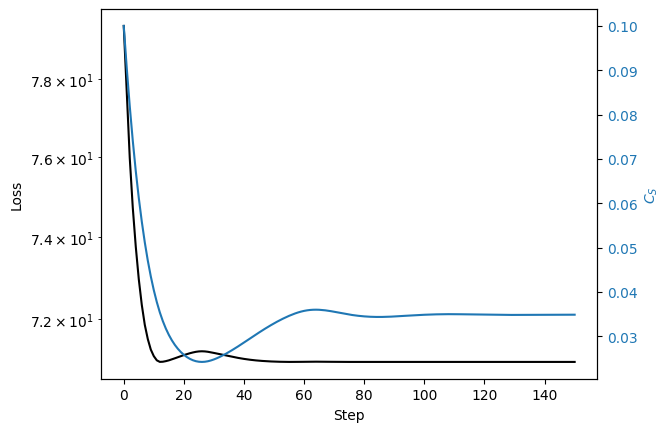

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("Step")

ax1.plot(jnp.asarray(losses).ravel(), color="black")
ax1.set_yscale("log")
ax1.set_ylabel("Loss")

ax2 = ax1.twinx()
ax2.plot([dyn.cs.item() for dyn in dyns], color="tab:blue")
ax2.set_ylabel("$C_S$", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

plt.show()

Using the initial and calibrated final values of $C_S$, we generate large ensembles of 1000 trajectories. This allows us to observe the differences between these ensembles and compare them against the deterministic prediction, which is represented by dashed lines below.

In [237]:
traj_ens_init = ens_sim(
    dynamics=stoch_smag_init,
    args=duacs_grid,
    x0=x0,
    ts=ts,
    dt0=dt0,
    n_samples=jnp.asarray(1000),
)
traj_est_init = traj_sim(dynamics=deter_smag_init, args=duacs_grid, x0=x0, ts=ts, dt0=dt0)

traj_ens_final = ens_sim(
    dynamics=stoch_smag_final,
    args=duacs_grid,
    x0=x0,
    ts=ts,
    dt0=dt0,
    n_samples=jnp.asarray(1000),
)
deter_smag_final = DeterministicSmagorinskyDiffusion.from_cs(cs=stoch_smag_final.cs)
traj_est_final = traj_sim(dynamics=deter_smag_final, args=duacs_grid, x0=x0, ts=ts, dt0=dt0)

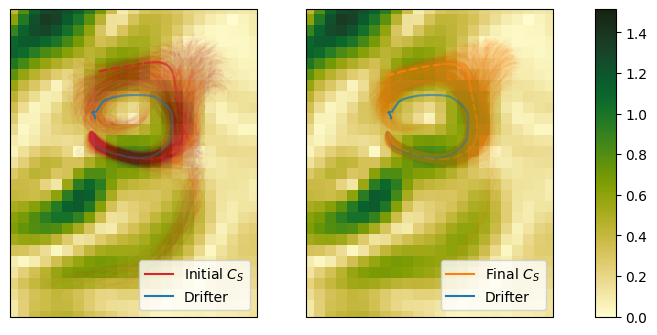

In [412]:
def get_extent(*trajs):
    min_lon = min([jnp.nanmin(traj.longitudes.value) for traj in trajs])
    max_lon = max([jnp.nanmax(traj.longitudes.value) for traj in trajs])
    min_lat = min([jnp.nanmin(traj.latitudes.value) for traj in trajs])
    max_lat = max([jnp.nanmax(traj.latitudes.value) for traj in trajs])

    return [min_lon - 0.25, max_lon + 0.25, min_lat - 0.25, max_lat + 0.25]


ds = duacs_ds.sel(time=drifter_ts[len(drifter_ts) // 2], method="nearest")

fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(7, 4.8))

im = ax1.pcolormesh(ds.longitude, ds.latitude, np.sqrt(ds.ugos**2 + ds.vgos**2), vmin=0, cmap=cmo.speed)

ax1 = traj_ens_final.plot(ax1, label="Final $C_S$", color="tab:orange", alpha_factor=0.25)
ax1 = traj_est_final.plot(ax1, color="tab:orange", linestyle="--")
ax1 = drifter_traj.plot(ax1, label="Drifter", color="tab:blue")

ax1.set_extent(get_extent(traj_ens_init, traj_est_init, traj_ens_final, traj_est_final, drifter_traj))

ax1.legend(loc="lower right")
ax1.coastlines()

im = ax2.pcolormesh(ds.longitude, ds.latitude, np.sqrt(ds.ugos**2 + ds.vgos**2), vmin=0, cmap=cmo.speed)

ax2 = traj_ens_init.plot(ax2, label="Initial $C_S$", color="tab:red", alpha_factor=0.25)
ax2 = traj_est_init.plot(ax2, color="tab:red", linestyle="--")
ax2 = drifter_traj.plot(ax2, label="Drifter", color="tab:blue")

ax2.set_extent(get_extent(traj_ens_init, traj_est_init, traj_ens_final, traj_est_final, drifter_traj))

ax2.legend(loc="lower right")
ax2.coastlines()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.96, 0.175, 0.03, 0.64])
fig.colorbar(im, cax=cbar_ax)

plt.show()

With large ensembles of sampled trajectories, we can further visualize the results using 2D histograms that better highlight the differences in spatial distribution and variability of the samplers.

In [331]:
def compute_hist2d(traj_ens, bins_center=(ds.longitude.values, ds.latitude.values)):
    hist2d = jax.vmap(
        lambda x, y: jnp.histogram2d(x, y, bins=bins_center, density=False)[0],
        in_axes=(1, 1),
    )(traj_ens.longitudes.value, traj_ens.latitudes.value)
    hist2d /= hist2d.sum(axis=(1, 2)).reshape(-1, 1, 1)  # normalize in space across time (no area consideration)
    hist2d = jnp.max(hist2d, axis=0)  # max over time
    hist2d = hist2d.T  # transpose to revert to Cartesian convention
    return hist2d


def get_confidence_mask(hist2d, conf_level=0.05):
    return jnp.where(hist2d >= conf_level, 0, jnp.nan)


hist2d_init = compute_hist2d(traj_ens_init)
hist2d_final = compute_hist2d(traj_ens_final)
conf_mask_init = get_confidence_mask(hist2d_init)
conf_mask_final = get_confidence_mask(hist2d_final)

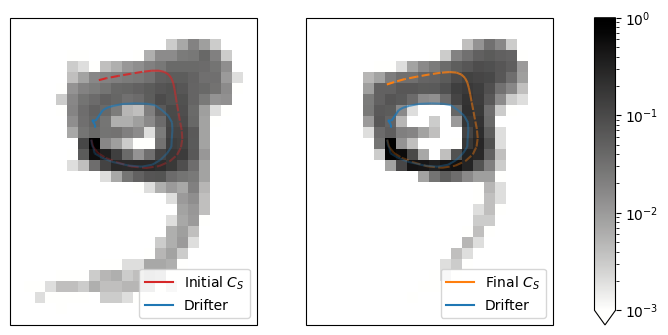

In [415]:
def get_extent(*trajs):
    min_lon = min([jnp.nanmin(traj.longitudes.value) for traj in trajs])
    max_lon = max([jnp.nanmax(traj.longitudes.value) for traj in trajs])
    min_lat = min([jnp.nanmin(traj.latitudes.value) for traj in trajs])
    max_lat = max([jnp.nanmax(traj.latitudes.value) for traj in trajs])

    return [min_lon - 0.25, max_lon + 0.25, min_lat - 0.25, max_lat + 0.25]


ds = duacs_ds.sel(time=drifter_ts[len(drifter_ts) // 2], method="nearest")

fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(7, 4.8))

im = ax1.pcolormesh(ds.longitude, ds.latitude, hist2d_final, cmap=cmo.gray_r, norm="log", vmin=1e-3)

ax1 = traj_est_final.plot(ax1, label="Final $C_S$", color="tab:orange", linestyle="--")
ax1 = drifter_traj.plot(ax1, label="Drifter", color="tab:blue")

ax1.set_extent(get_extent(traj_ens_init, traj_est_init, traj_ens_final, traj_est_final, drifter_traj))

ax1.legend(loc="lower right")
ax1.coastlines()

im = ax2.pcolormesh(ds.longitude, ds.latitude, hist2d_init, cmap=cmo.gray_r, norm="log", vmin=1e-3)

ax2 = traj_est_init.plot(ax2, label="Initial $C_S$", color="tab:red", linestyle="--")
ax2 = drifter_traj.plot(ax2, label="Drifter", color="tab:blue")

ax2.set_extent(get_extent(traj_ens_init, traj_est_init, traj_ens_final, traj_est_final, drifter_traj))

ax2.legend(loc="lower right")
ax2.coastlines()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.96, 0.175, 0.03, 0.64])
fig.colorbar(im, cax=cbar_ax, extend="min")

plt.show()

With this very simple model we see that we can calibrate both the deterministic and the stochastic terms of the drift dynamics, provided that we employ an appropriate loss function.